In [614]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import RandomOverSampler

In [615]:
gc_df=pd.read_csv('./german_credit_data.csv')
print(gc_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Unnamed: 0        1000 non-null   int64 
 1   Age               1000 non-null   int64 
 2   Sex               1000 non-null   object
 3   Job               1000 non-null   int64 
 4   Housing           1000 non-null   object
 5   Saving accounts   817 non-null    object
 6   Checking account  606 non-null    object
 7   Credit amount     1000 non-null   int64 
 8   Duration          1000 non-null   int64 
 9   Purpose           1000 non-null   object
 10  Risk              1000 non-null   object
dtypes: int64(5), object(6)
memory usage: 86.1+ KB
None


In [616]:
gc_df.sample(10)

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
156,156,48,male,2,own,moderate,little,1288,9,repairs,good
996,996,40,male,3,own,little,little,3857,30,car,good
227,227,53,male,3,free,little,little,7865,12,furniture/equipment,bad
546,546,37,female,2,own,little,NaN,2022,24,car,good
26,26,39,male,1,own,little,NaN,426,6,radio/TV,good
178,178,31,male,3,rent,little,NaN,1963,12,radio/TV,good
455,455,29,female,3,own,little,NaN,2679,24,car,good
529,529,41,male,1,own,little,little,662,6,car,good
540,540,23,male,2,rent,little,moderate,1534,12,radio/TV,bad
603,603,28,female,3,own,little,NaN,3349,36,furniture/equipment,bad


In [617]:
gc_df.isna().sum(),gc_df.duplicated().sum()

(Unnamed: 0            0
 Age                   0
 Sex                   0
 Job                   0
 Housing               0
 Saving accounts     183
 Checking account    394
 Credit amount         0
 Duration              0
 Purpose               0
 Risk                  0
 dtype: int64,
 np.int64(0))

In [618]:
gc_df.drop(columns=['Unnamed: 0'], inplace=True)
gc_df.fillna({'Checking account': 'no checking account'}, inplace=True)
gc_df.fillna({'Saving accounts': 'no savings account'}, inplace=True)
gc_df.sample(10)

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
682,33,male,2,own,little,no checking account,1478,15,radio/TV,good
731,21,male,1,rent,little,little,1987,24,radio/TV,bad
353,28,male,2,rent,little,little,6199,12,radio/TV,bad
224,30,male,2,own,little,no checking account,4657,15,car,good
815,54,female,2,rent,little,moderate,7432,36,car,good
930,24,male,1,own,little,little,1747,24,furniture/equipment,good
239,39,male,2,own,little,little,2522,30,radio/TV,good
279,29,male,3,rent,moderate,no checking account,1901,24,radio/TV,good
264,32,male,1,own,little,no checking account,1231,10,car,good
751,23,female,1,own,little,little,976,18,car,bad


In [619]:
gc_df['Checking account'].value_counts(),gc_df['Saving accounts'].value_counts(),gc_df['Housing'].value_counts()

(Checking account
 no checking account    394
 little                 274
 moderate               269
 rich                    63
 Name: count, dtype: int64,
 Saving accounts
 little                603
 no savings account    183
 moderate              103
 quite rich             63
 rich                   48
 Name: count, dtype: int64,
 Housing
 own     713
 rent    179
 free    108
 Name: count, dtype: int64)

In [620]:
gc_df.Risk.value_counts()

Risk
good    700
bad     300
Name: count, dtype: int64

In [621]:
essential = ['education', 'domestic appliances','repairs']
conditional_Essential=['business','furniture/equipment','car']
nonEssential=['radio/TV','vacation/others']
gc_df['Purpose'] = gc_df['Purpose'].apply(lambda x: 'essential' if x in essential else 'conditional_essential' if x in conditional_Essential else 'nonEssential' if x in nonEssential else x)
gc_df['Purpose'].value_counts()

Purpose
conditional_essential    615
nonEssential             292
essential                 93
Name: count, dtype: int64

In [622]:
gc_df.sample(10)

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
702,47,female,2,free,moderate,rich,1377,24,nonEssential,good
139,44,female,1,rent,little,rich,1881,12,nonEssential,good
102,24,female,2,own,little,no checking account,932,6,nonEssential,good
564,37,male,3,own,no savings account,moderate,4712,24,conditional_essential,good
810,26,male,2,own,little,moderate,907,8,conditional_essential,good
774,66,male,0,free,quite rich,rich,1480,12,conditional_essential,good
52,25,male,2,own,little,no checking account,1262,12,nonEssential,good
615,48,male,3,own,no savings account,moderate,12204,48,conditional_essential,good
218,24,male,1,rent,little,little,3021,24,conditional_essential,good
360,61,male,2,free,no savings account,moderate,1239,18,essential,good


In [623]:
gc_df.describe()

,Age,Job,Credit amount,Duration
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,35.546000,1.904000,3271.258000,20.903000
std,11.375469,0.653614,2822.736876,12.058814
min,19.000000,0.000000,250.000000,4.000000
25%,27.000000,2.000000,1365.500000,12.000000
50%,33.000000,2.000000,2319.500000,18.000000
75%,42.000000,2.000000,3972.250000,24.000000
max,75.000000,3.000000,18424.000000,72.000000


In [624]:
gc_df.describe(include='object')

,Sex,Housing,Saving accounts,Checking account,Purpose,Risk
count,1000,1000,1000,1000,1000,1000
unique,2,3,5,4,3,2
top,male,own,little,no checking account,conditional_essential,good
freq,690,713,603,394,615,700


In [625]:
gc_df['Checking account']=gc_df['Checking account'].map({'no checking account':0,'little':1,'moderate':2,'rich':3})
gc_df['Saving accounts']=gc_df['Saving accounts'].map({'no savings account':0,'little':1,'moderate':2,'quite rich':3,'rich':4})
gc_df['Housing']=gc_df['Housing'].map({'own':1,'free':0,'rent':2})
# gc_df['Purpose']=gc_df['Purpose'].map({'radio/TV':0,'vacation/others':1,'furniture/equipment':2,'business':3,'domestic appliances':4,'repairs':5,'education':6,'car':7})
gc_df['Purpose']=gc_df['Purpose'].map({'essential':0,'conditional_essential':1,'nonEssential':2})
gc_df['Sex']=gc_df['Sex'].map({'male':0,'female':1})
gc_df['Risk']=gc_df['Risk'].map({'bad':0,'good':1}).astype(int)


In [626]:
gc_df.isna().sum(),gc_df.duplicated().sum()

(Age                 0
 Sex                 0
 Job                 0
 Housing             0
 Saving accounts     0
 Checking account    0
 Credit amount       0
 Duration            0
 Purpose             0
 Risk                0
 dtype: int64,
 np.int64(0))

In [627]:
px.box(gc_df,x='Duration', color='Risk', title='Duration vs Risk', height=400).show()
px.box(gc_df,x='Credit amount', color='Risk', title='Credit amount vs Risk', height=400).show()
px.box(gc_df,x='Age', color='Housing', title='Age vs Risk', height=400).show()

In [628]:
gc_df['Age'].mean()

np.float64(35.546)

In [629]:
gc_df.sample(10)

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
85,29,1,3,1,1,0,1412,12,1,1
321,32,0,2,1,1,1,1938,24,2,0
775,25,1,2,2,0,1,1371,24,1,0
877,28,0,2,1,1,0,3595,36,2,1
555,22,0,2,1,1,2,1331,12,2,0
959,30,0,2,0,2,2,3069,24,1,1
198,36,0,2,0,0,2,2760,24,1,1
615,48,0,3,1,0,2,12204,48,1,1
488,35,0,1,2,2,0,1418,10,1,1
747,37,1,1,1,1,1,1274,12,1,0


Text(0.5, 1.0, 'Correlation with Risk')

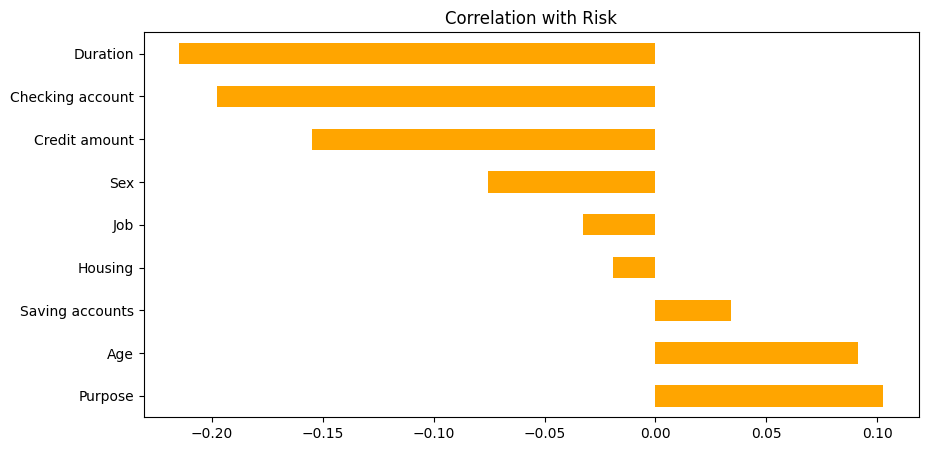

In [630]:
correlation_values = gc_df.corr()['Risk'].drop('Risk').sort_values(ascending=False)
correlation_values.plot(kind='barh', figsize=(10, 5), color='orange')
plt.title('Correlation with Risk')


In [631]:
X=gc_df.drop(columns=['Risk'])
y=gc_df['Risk']
ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train_ros, X_test_ros, y_train_ros, y_test_ros = train_test_split(X_res, y_res, test_size=0.2, random_state=42, stratify=y_res)

In [632]:

model=LogisticRegression(class_weight='balanced', max_iter=1000)
model.fit(X_train,y_train)
y_pred=model.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
y_proba=model.predict_proba(X_test)
y_proba[:10]

[[36 24]
 [58 82]]
              precision    recall  f1-score   support

           0       0.38      0.60      0.47        60
           1       0.77      0.59      0.67       140

    accuracy                           0.59       200
   macro avg       0.58      0.59      0.57       200
weighted avg       0.66      0.59      0.61       200



d:\vs-code\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



array([[0.55863589, 0.44136411],
       [0.90911207, 0.09088793],
       [0.79618965, 0.20381035],
       [0.24623604, 0.75376396],
       [0.76243692, 0.23756308],
       [0.5260821 , 0.4739179 ],
       [0.2922454 , 0.7077546 ],
       [0.17948314, 0.82051686],
       [0.60679933, 0.39320067],
       [0.19605514, 0.80394486]])

In [633]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_ros, y_train_ros)
y_pred_rf = rf_model.predict(X_test_ros)
print(confusion_matrix(y_test_ros, y_pred_rf))
print(classification_report(y_test_ros, y_pred_rf))
y_proba_rf = rf_model.predict_proba(X_test_ros)
y_proba_rf[:10]

[[136   4]
 [ 28 112]]
              precision    recall  f1-score   support

           0       0.83      0.97      0.89       140
           1       0.97      0.80      0.88       140

    accuracy                           0.89       280
   macro avg       0.90      0.89      0.88       280
weighted avg       0.90      0.89      0.88       280



array([[0.89, 0.11],
       [0.51, 0.49],
       [0.96, 0.04],
       [1.  , 0.  ],
       [0.95, 0.05],
       [0.98, 0.02],
       [0.17, 0.83],
       [0.75, 0.25],
       [0.36, 0.64],
       [0.17, 0.83]])

In [634]:
xgboost_model = XGBClassifier( random_state=42)
xgboost_model.fit(X_train_ros, y_train_ros)
y_pred_xgb = xgboost_model.predict(X_test_ros)
print(confusion_matrix(y_test_ros, y_pred_xgb))
print(classification_report(y_test_ros, y_pred_xgb))
y_proba_xgb = xgboost_model.predict_proba(X_test_ros)
y_proba_xgb[:10]

[[134   6]
 [ 31 109]]
              precision    recall  f1-score   support

           0       0.81      0.96      0.88       140
           1       0.95      0.78      0.85       140

    accuracy                           0.87       280
   macro avg       0.88      0.87      0.87       280
weighted avg       0.88      0.87      0.87       280



array([[9.2380571e-01, 7.6194264e-02],
       [5.7520068e-01, 4.2479935e-01],
       [9.9617529e-01, 3.8246817e-03],
       [9.7318578e-01, 2.6814220e-02],
       [9.3293649e-01, 6.7063525e-02],
       [9.7712851e-01, 2.2871519e-02],
       [9.1814995e-04, 9.9908185e-01],
       [8.3816731e-01, 1.6183266e-01],
       [1.8759131e-01, 8.1240869e-01],
       [8.1715107e-02, 9.1828489e-01]], dtype=float32)

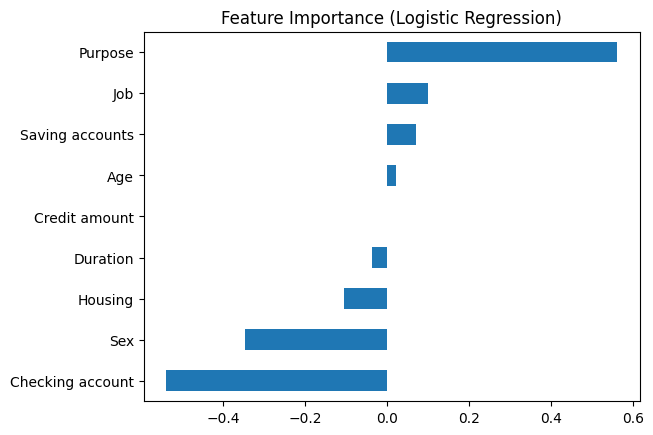

In [635]:
coef_df = pd.Series(model.coef_[0], index=X.columns)
coef_df.sort_values().plot(kind='barh', title='Feature Importance (Logistic Regression)')
plt.show()

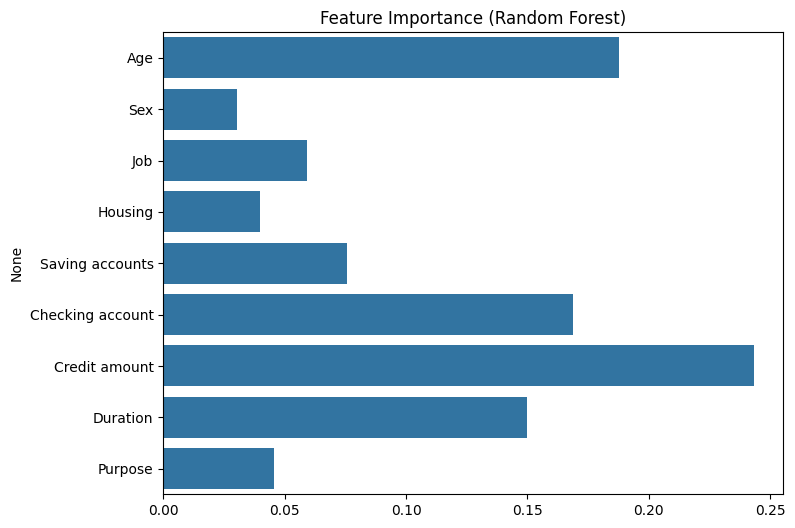

In [636]:
importances = rf_model.feature_importances_
feat_names = X.columns

plt.figure(figsize=(8,6))
sns.barplot(x=importances, y=feat_names)
plt.title("Feature Importance (Random Forest)")
plt.show()


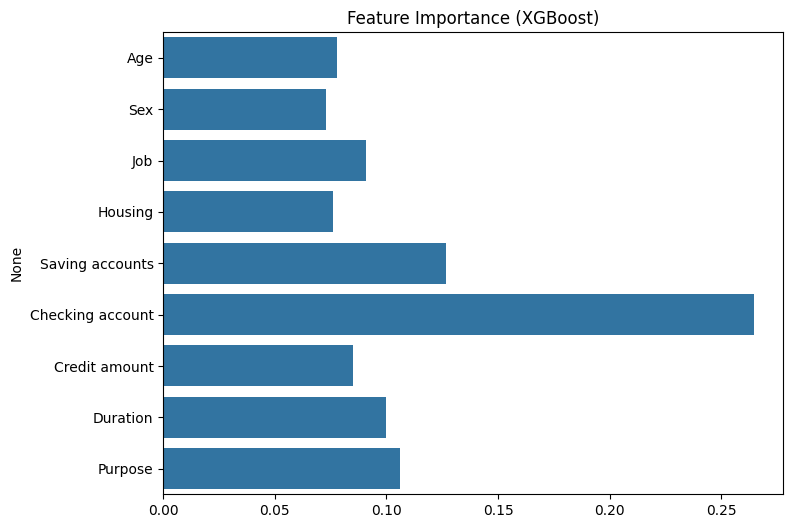

In [637]:
importances = xgboost_model.feature_importances_
feat_names = X.columns
plt.figure(figsize=(8,6))
sns.barplot(x=importances, y=feat_names)
plt.title("Feature Importance (XGBoost)")
plt.show()


In [638]:
col=['RandomForestClassifier','XGBoostClassifier','LogisticRegression']
result1=[accuracy_score(y_test_ros,y_pred_rf),accuracy_score(y_test_ros,y_pred_xgb),accuracy_score(y_test,y_pred)]
result2=[recall_score(y_test_ros,y_pred_rf),recall_score(y_test_ros,y_pred_xgb),recall_score(y_test,y_pred)]
result3=[f1_score(y_test_ros,y_pred_rf),f1_score(y_test_ros,y_pred_xgb),f1_score(y_test,y_pred)]
final = pd.DataFrame({'Algorithms':col,'Accuracy':result1,'Recall':result2,'F1':result3})
final

,Algorithms,Accuracy,Recall,F1
0,RandomForestClassifier,0.885714,0.800000,0.875000
1,XGBoostClassifier,0.867857,0.778571,0.854902
2,LogisticRegression,0.590000,0.585714,0.666667


In [639]:
final_melted = final.melt(id_vars='Algorithms', value_vars=['Accuracy', 'Recall', 'F1'], var_name='Metric', value_name='Score')
fig = px.line(final_melted, x='Algorithms', y='Score', color='Metric', markers=True, title='Model Performance Comparison', labels={'Score': 'Metric Score', 'Algorithms': 'Model'})
fig.show()